## Xiaolin Liu
##### z5519304

### library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as sm
import sklearn.preprocessing as sp
import joblib, pickle
from sklearn.neural_network import MLPClassifier, MLPRegressor 
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, recall_score, mean_absolute_error, mean_squared_error
from scipy.stats    import pearsonr
import warnings
from sklearn.exceptions import ConvergenceWarning

## Task A – Classification 

### --- Data preparation

In [2]:
Atemp_df = pd.read_csv("Amazon_temperature_student.csv")
thresholds_df = pd.read_csv("thresholds.csv")
merged_df = pd.merge(Atemp_df, thresholds_df, on="month")
merged_df["Hot"] = np.where(merged_df["temperature"] > merged_df["threshold"], 1, 0)

### --- Bar plot

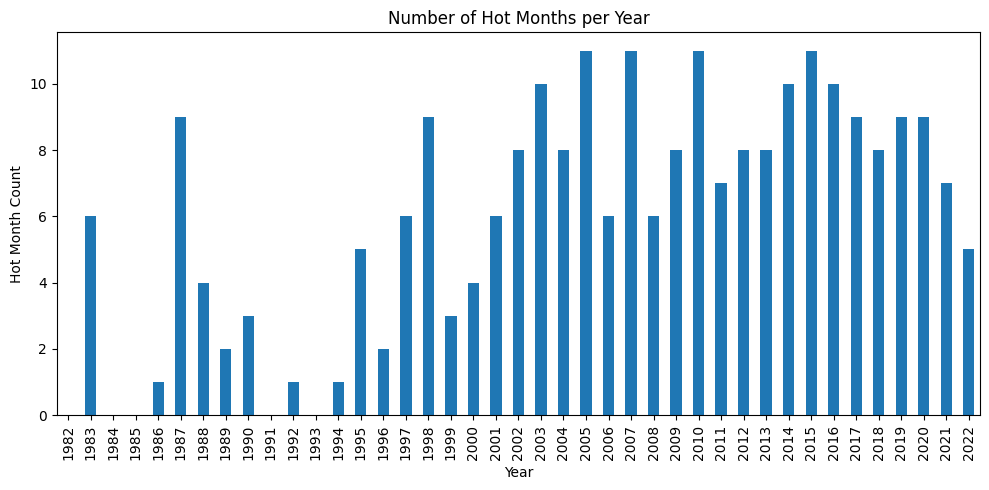

In [3]:
hot_per_year = merged_df.groupby("year")["Hot"].sum()
hot_per_year.plot(kind="bar", figsize=(10, 5))
plt.title("Number of Hot Months per Year")
plt.xlabel("Year")
plt.ylabel("Hot Month Count")
plt.tight_layout()
plt.show()

### --- Model development

#### ---- Partition the dataset

In [4]:
angle = 2 * np.pi * (merged_df["month"] - 1) / 12
merged_df["month_sin"] = np.sin(angle)
merged_df["month_cos"] = np.cos(angle)

In [5]:
train_df, temp_df = sm.train_test_split(merged_df, test_size=0.3, random_state=16)
val_df, test_df = sm.train_test_split(temp_df, test_size=0.5, random_state=16)

In [6]:
features = ["TSA", "ENSO", "NAO", "TNA", "month_sin", "month_cos"]

x_train = train_df[features]
y_train_hot = train_df["Hot"]

x_val = val_df[features]
y_val_hot = val_df["Hot"]

x_test = test_df[features]
y_test_hot = test_df["Hot"]

#### ---- Data preprocessing

In [7]:
scaler = sp.StandardScaler()
scaler.fit(x_train)       
X_train_scaled = scaler.transform(x_train)  
X_val_scaled = scaler.transform(x_val)      
X_test_scaled = scaler.transform(x_test)  

#### ---- Build model_A

In [8]:
model_A = MLPClassifier(
    hidden_layer_sizes=(4,),     
    activation='relu',          
    max_iter=500,               
    solver='adam',               
    learning_rate_init=0.01,     
    random_state=16
)

#### ---- Accuracy vs epochs plot

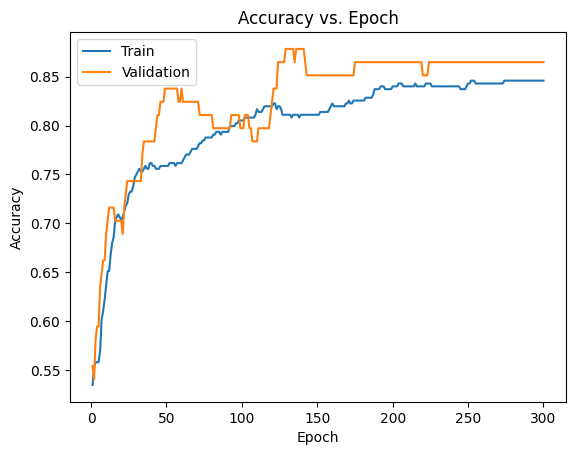

In [9]:
train_acc = []
val_acc = []
for epoch in range(300):
    model_A.partial_fit(X_train_scaled, y_train_hot, classes=[0, 1])
    
    y_train_hot_pred = model_A.predict(X_train_scaled)
    y_val_hot_pred = model_A.predict(X_val_scaled)
    
    train_acc.append(accuracy_score(y_train_hot, y_train_hot_pred))
    val_acc.append(accuracy_score(y_val_hot,   y_val_hot_pred))

plt.plot(range(1, 301), train_acc, label='Train')
plt.plot(range(1, 301), val_acc,   label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epoch')
plt.show()

### Model evaluation

#### ---- Confusion Matrix

Balanced Accuracy: 0.770
TPR (Sensitivity): 0.730
TNR (Specificity): 0.811


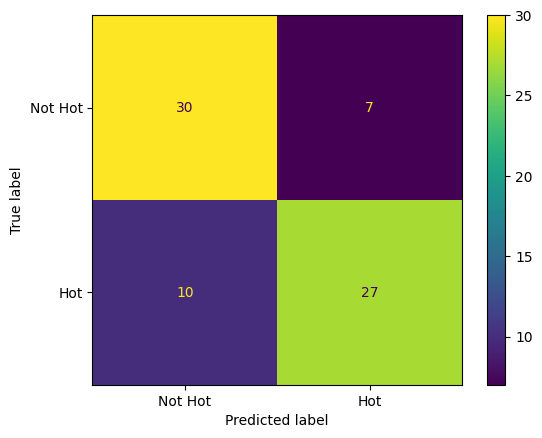

In [10]:
y_test_hot_pred = model_A.predict(X_test_scaled)

cm = confusion_matrix(y_test_hot, y_test_hot_pred, labels=[0, 1])
ConfusionMatrixDisplay(cm, display_labels=['Not Hot', 'Hot']).plot()

bal_acc = balanced_accuracy_score(y_test_hot, y_test_hot_pred)   
tpr = recall_score(y_test_hot, y_test_hot_pred, pos_label=1) 
tnr = recall_score(y_test_hot, y_test_hot_pred, pos_label=0) 

print(f'Balanced Accuracy: {bal_acc:.3f}')
print(f'TPR (Sensitivity): {tpr:.3f}')
print(f'TNR (Specificity): {tnr:.3f}')

## Task B – Regression

### --- Model development

#### ---- Data preparation

In [11]:
# already have X_train_scaled, X_val_scaled, X_test_scaled with 6 features in task A
y_train_temp = train_df['temperature']
y_val_temp = val_df['temperature']
y_test_temp = test_df['temperature']

#### ---- Build model_B

In [12]:
model_B = MLPRegressor(
    hidden_layer_sizes=(4,),    
    activation='relu',       
    solver='adam',            
    learning_rate_init=0.01,    
    max_iter=800,              
    random_state=16
)

In [13]:
model_B.fit(X_train_scaled, y_train_temp)

MLPRegressor(hidden_layer_sizes=(4,), learning_rate_init=0.01, max_iter=800,
             random_state=16)

#### ---- Loss vs epochs plot

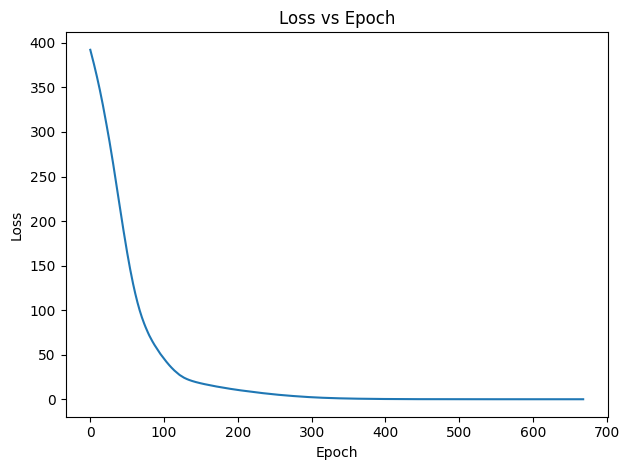

In [14]:
plt.plot(model_B.loss_curve_)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.tight_layout()
plt.show()

### --- Model evaluation

In [15]:
y_test_temp_pred = model_B.predict(X_test_scaled)

mae = mean_absolute_error(y_test_temp, y_test_temp_pred)
r, _ = pearsonr(y_test_temp, y_test_temp_pred)

print(f"Pearson r: {r:.3f}")
print(f"Mean Absolute Error: {mae:.3f}")

Pearson r: 0.828
Mean Absolute Error: 0.298


### --- Model development

#### ---- Partition the dataset

In [16]:
years = merged_df["year"].unique()

train_years, temp_years = sm.train_test_split(years, test_size = 0.3, random_state = 16)
val_years, test_years = sm.train_test_split(temp_years, test_size = 0.5, random_state = 16)

train_year_df = merged_df[ merged_df["year"].isin(train_years)].copy()
val_year_df   = merged_df[ merged_df["year"].isin(val_years)].copy()
test_year_df  = merged_df[ merged_df["year"].isin(test_years)].copy()

features = ["TSA", "ENSO", "NAO", "TNA", "month_sin", "month_cos"]

x_train_year = train_year_df[features]
y_train_temp2 = train_year_df["temperature"]

x_val_year = val_year_df[features]
y_val_temp2   = val_year_df["temperature"]

x_test_year = test_year_df[features]
y_test_temp2  = test_year_df["temperature"]

#### ---- Data preprocessing

In [17]:
# the scaler already fit in task_A
X_train_year_scaled = scaler.transform(x_train_year)
X_val_year_scaled   = scaler.transform(x_val_year)
X_test_year_scaled  = scaler.transform(x_test_year)

In [18]:
temp_scaler = sp.StandardScaler()

y_train_temp2_reshaped = y_train_temp2.values.reshape(-1, 1)
y_val_temp2_reshaped = y_val_temp2.values.reshape(-1, 1)
y_test_temp2_reshaped = y_test_temp2.values.reshape(-1, 1)

temp_scaler.fit(y_train_temp2_reshaped)

Y_train_temp2_scaled = temp_scaler.transform(y_train_temp2_reshaped).ravel()
Y_val_temp2_scaled = temp_scaler.transform(y_val_temp2_reshaped).ravel()
Y_test_temp2_scaled = temp_scaler.transform(y_test_temp2_reshaped).ravel()

#### ---- Re-train

In [19]:
model_B2 = MLPRegressor(
    hidden_layer_sizes=(4,),    
    activation='relu',        
    solver='adam',             
    learning_rate_init=0.01,    
    max_iter=1,              
    random_state=16,
    warm_start=True    
)

In [20]:
train_losses = []
val_losses   = []
epochs = 200 

warnings.filterwarnings("ignore", category=ConvergenceWarning)
for epoch in range(epochs):
    
    model_B2.fit(X_train_year_scaled, Y_train_temp2_scaled)
    train_losses.append(model_B2.loss_curve_[-1])

    y_val_temp2_pred = model_B2.predict(X_val_year_scaled)
    val_losses.append(mean_squared_error(Y_val_temp2_scaled, y_val_temp2_pred))

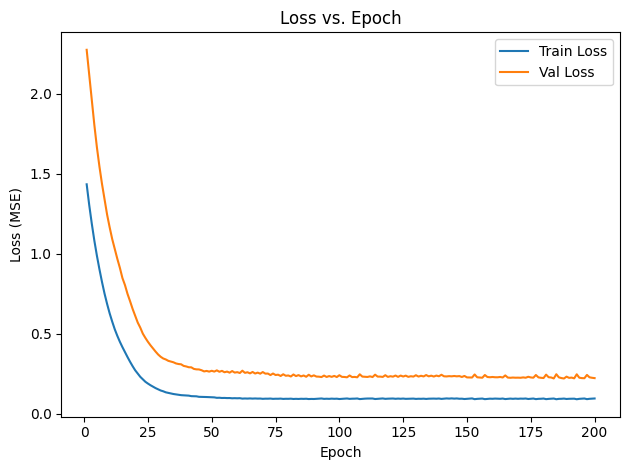

In [21]:
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Loss vs. Epoch')
plt.legend()
plt.tight_layout()
plt.show()

#### ---- Model evaluation

In [22]:
y_test_temp2_scaled_pred = model_B2.predict(X_test_year_scaled)
y_test_temp2_pred = temp_scaler.inverse_transform(y_test_temp2_scaled_pred.reshape(-1,1)).ravel()

mae2 = mean_absolute_error(y_test_temp2.values, y_test_temp2_pred)
r2, _ = pearsonr(y_test_temp2.values, y_test_temp2_pred)

print(f"Pearson r: {r2:.3f}")
print(f"Mean Absolute Error: {mae2:.3f}")

Pearson r: 0.919
Mean Absolute Error: 0.226


# Save

In [23]:
joblib.dump(model_A, "model_A_class_random.pkl")
joblib.dump(model_B, "model_B_reg_random.pkl")
joblib.dump(model_B2, "model_B2_reg_yearwise.pkl")
joblib.dump(scaler, "scaler_feat_random.pkl")
joblib.dump(temp_scaler, "scaler_target_yearwise.pkl")

['scaler_target_yearwise.pkl']

# Testing

In [ ]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix, ConfusionMatrixDisplay,
    mean_absolute_error
)
from scipy.stats import pearsonr

# 1) prepare test_df
test_df = pd.read_csv('hidden.csv')  
thresholds_df = pd.read_csv("thresholds.csv")
test_df = pd.merge(test_df, thresholds_df, on="month")
test_df["Hot"] = np.where(test_df["temperature"] > test_df["threshold"], 1, 0)

# 2) rebuild month_sin/month_cos and features
angle = 2 * np.pi * (test_df['month'] - 1) / 12
test_df['month_sin'] = np.sin(angle)
test_df['month_cos'] = np.cos(angle)

features = ['TSA', 'ENSO', 'NAO', 'TNA', 'month_sin', 'month_cos']
X_test_feat = test_df[features].values

# target
y_test_hot  = test_df['Hot'].values
y_test_temp = test_df['temperature'].values

# 3) recovery model and Scaler
model_A    = joblib.load('model_A_class_random.pkl')
scaler_feat= joblib.load('scaler_feat_random.pkl')

model_B    = joblib.load('model_B_reg_random.pkl')

model_B2   = joblib.load('model_B2_reg_yearwise.pkl')
temp_scaler= joblib.load('scaler_target_yearwise.pkl')

# 4) Evaluate classifier
X_test_scaled = scaler_feat.transform(X_test_feat)
y_pred_hot    = model_A.predict(X_test_scaled)

bal_acc = balanced_accuracy_score(y_test_hot, y_pred_hot)
print(f'Classification – Balanced Accuracy: {bal_acc:.3f}')

cm = confusion_matrix(y_test_hot, y_pred_hot, labels=[0,1])
disp = ConfusionMatrixDisplay(cm, display_labels=['Not Hot','Hot'])
disp.plot(cmap='Blues')
plt.title('Classifier Confusion Matrix')
plt.show()

# 5) Evaluate Random-Split Regressor
y_pred_temp_random = model_B.predict(X_test_scaled)

plt.figure(figsize=(6,6))
plt.scatter(y_test_temp, y_pred_temp_random, alpha=0.6)
mn, mx = y_test_temp.min(), y_test_temp.max()
plt.plot([mn,mx],[mn,mx],'r--',label='y = x')
plt.xlabel('True Temperature')
plt.ylabel('Predicted Temperature')
plt.title('Random-split Regressor: True vs Predicted')
plt.legend()
plt.tight_layout()
plt.show()

# 6) Evaluate Year-wise Regressor
y_pred_scaled_year = model_B2.predict(X_test_scaled)
y_pred_temp_year   = temp_scaler.inverse_transform(
    y_pred_scaled_year.reshape(-1,1)
).ravel()

plt.figure(figsize=(6,6))
plt.scatter(y_test_temp, y_pred_temp_year, alpha=0.6)
plt.plot([mn,mx],[mn,mx],'r--',label='y = x')
plt.xlabel('True Temperature')
plt.ylabel('Predicted Temperature')
plt.title('Year-wise Regressor: True vs Predicted')
plt.legend()
plt.tight_layout()
plt.show()

# 7) MAE & Pearson r
mae_rnd = mean_absolute_error(y_test_temp, y_pred_temp_random)
r_rnd, _ = pearsonr(y_test_temp, y_pred_temp_random)
print(f'Random-split Regressor – MAE: {mae_rnd:.3f}, Pearson r: {r_rnd:.3f}')

mae_yr = mean_absolute_error(y_test_temp, y_pred_temp_year)
r_yr, _ = pearsonr(y_test_temp, y_pred_temp_year)
print(f'Year-wise Regressor – MAE: {mae_yr:.3f}, Pearson r: {r_yr:.3f}')
